In [63]:
import xarray as xr
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from math import e
from joblib import dump, load
import xskillscore as xs
import cartopy.crs as ccrs
import iris
import iris.plot as iplt
import iris.quickplot as qplt
import matplotlib.cm as mpl_cm
from eofs.xarray import Eof
import cartopy.crs as ccrs
import matplotlib.ticker as ticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

# Fog Station data

In [64]:
fogData = xr.open_dataset('../../../Data/FogData/CombinedFogData_25Stations.nc')

In [65]:
StackFog=fogData.fogdata.stack(a=('years','months','days'))
StackFog
dd =[];
for i in range(StackFog.years.values.shape[0]):
    dd=dd+[str(StackFog.years[i].values)+'-'+str(StackFog.months[i].values)+"-"+str(StackFog.days[i].values)]
fg = xr.Dataset({'fogdata': (('time','stations'), StackFog.values.T)}, coords={'time': pd.to_datetime(dd),'stations': fogData.stations})
yAll=fg.fogdata.sum(dim='stations').sel(time=slice('1980-12-1','2014-1-31'))
yAll=yAll/25.0
yWd= yAll[yAll >0.44]
yWd
yAll

<xarray.DataArray 'fogdata' (time: 2108)>
array([0.12, 0.12, 0.12, ..., 0.72, 0.68, 0.56])
Coordinates:
  * time     (time) datetime64[ns] 1980-12-01 1980-12-02 ... 2014-01-31

# ERA5

In [66]:
z500Data = xr.open_dataset('../../../Data/eraDown/ERA5_2degree_Down/DailyMean/ERA5NH_500_z_daily_NovDecJan.nc')
z500Data
z=z500Data.z.shift(time=1)
z.values=z.values/9.81
#z
z

<xarray.DataArray 'z' (time: 3772, latitude: 46, longitude: 180)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[5129.0015, 5129.0015, 5129.0015, ..., 5129.0015, 5129.0015,
         5129.0015],
        [5084.0093, 5081.8154, 5079.643 , ..., 5090.592 , 5088.3755,
         5086.181 ],
        [5048.658 , 5044.0264, 5039.394 , ..., 5062.2   , 5057.5903,
         5053.1353],
...
        [5863.128 , 5862.906 , 5863.748 , ..., 5863.704 , 5863.46  ,
         5863.482 ],
        [5863.571 , 5864.5684, 5862.7065, ..., 5864.1694, 5863.3716,
         5863.2607],
        [5862.64  , 5863.039 , 5865.189 , ..., 5864.6567, 5863.5483,
         5863.9697]],

       [[4955.615 , 4955.615 , 4955.615 , ..., 4955.615 , 4955.615 ,
         4955.615 ],
        [4976.2056, 4977.1143, 4977.9565, ..., 4973.1025, 4974.1885,
         4975.2524],
        [4995.931 , 4997.2827, 4998.4575, ..., 4990.922 , 4992.5845,
         4994.313 ],
        ...,
        [5861.576 , 5862.64  , 5862.773 , ..., 5858.939 , 5860.6455,
         5861.    ],
        [5863.659 , 5863.1943, 5863.1943, ..., 5860.224 , 5861.133 ,
         5861.8867],
        [5865.167 , 5864.546 , 5864.7456, ..., 5861.31  , 5862.884 ,
         5864.147 ]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01T09:00:00 ... 2019-12-31T09:00:00
  * longitude  (longitude) float32 0.0 2.0 4.0 6.0 ... 352.0 354.0 356.0 358.0
  * latitude   (latitude) float32 90.0 88.0 86.0 84.0 82.0 ... 6.0 4.0 2.0 0.0
Attributes:
    standard_name:  geopotential
    long_name:      Geopotential
    units:          m**2 s**-2

# Calculate daily Anomaly

In [67]:
da = z.assign_coords(month_day=z.time.dt.strftime("%m-%d"))
dailyAnomZ = da.groupby("month_day") - da.groupby("month_day").mean("time")
decJanAnomz=dailyAnomZ[(dailyAnomZ.time.dt.month>11) | (dailyAnomZ.time.dt.month<2)].sel(time=slice('1980-12-1','2014-1-31'))
yAll['time'] = decJanAnomz.time
da

<xarray.DataArray 'z' (time: 3772, latitude: 46, longitude: 180)>
array([[[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[5129.0015, 5129.0015, 5129.0015, ..., 5129.0015, 5129.0015,
         5129.0015],
        [5084.0093, 5081.8154, 5079.643 , ..., 5090.592 , 5088.3755,
         5086.181 ],
        [5048.658 , 5044.0264, 5039.394 , ..., 5062.2   , 5057.5903,
         5053.1353],
...
        [5863.128 , 5862.906 , 5863.748 , ..., 5863.704 , 5863.46  ,
         5863.482 ],
        [5863.571 , 5864.5684, 5862.7065, ..., 5864.1694, 5863.3716,
         5863.2607],
        [5862.64  , 5863.039 , 5865.189 , ..., 5864.6567, 5863.5483,
         5863.9697]],

       [[4955.615 , 4955.615 , 4955.615 , ..., 4955.615 , 4955.615 ,
         4955.615 ],
        [4976.2056, 4977.1143, 4977.9565, ..., 4973.1025, 4974.1885,
         4975.2524],
        [4995.931 , 4997.2827, 4998.4575, ..., 4990.922 , 4992.5845,
         4994.313 ],
        ...,
        [5861.576 , 5862.64  , 5862.773 , ..., 5858.939 , 5860.6455,
         5861.    ],
        [5863.659 , 5863.1943, 5863.1943, ..., 5860.224 , 5861.133 ,
         5861.8867],
        [5865.167 , 5864.546 , 5864.7456, ..., 5861.31  , 5862.884 ,
         5864.147 ]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1979-01-01T09:00:00 ... 2019-12-31T09:00:00
  * longitude  (longitude) float32 0.0 2.0 4.0 6.0 ... 352.0 354.0 356.0 358.0
  * latitude   (latitude) float32 90.0 88.0 86.0 84.0 82.0 ... 6.0 4.0 2.0 0.0
    month_day  (time) object '01-01' '01-02' '01-03' ... '12-29' '12-30' '12-31'
Attributes:
    standard_name:  geopotential
    long_name:      Geopotential
    units:          m**2 s**-2

In [68]:
# oromask
mask=load('oroMask.joblib')
mask

array([[[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,  1.,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,  1.,
          1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan],
        [ 1., nan, nan, nan, nan, nan,  1., nan, nan, nan, nan,  1.,
          1.,  1.,  1., nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan],
        [ 1.,  1., nan, nan, nan, nan, nan, nan, nan,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1., nan, nan, nan, nan, nan, nan, nan,
         nan, nan],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1., nan,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., nan,
         nan, nan],
        [ 1.,  1.,  1., nan,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
          1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., nan,  1.,
         nan, nan],
        [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.

In [69]:
# get WFD daily anomaly
wfdZ=decJanAnomz[yAll >0.44,:,:]
wfdZ.time
wfdZ
print(wfdZ.time.shape)
ndays=wfdZ.time.shape[0]
print(ndays)



(459,)
459


In [70]:
def map_plot(ax1):
    ax1.coastlines()
    ax1.set_xticks([50,60 , 70,80, 90,100], crs=ccrs.PlateCarree())
    ax1.set_yticks([ 5,10,15,20,25,30], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)

# Composite of WFD

(18, 26)


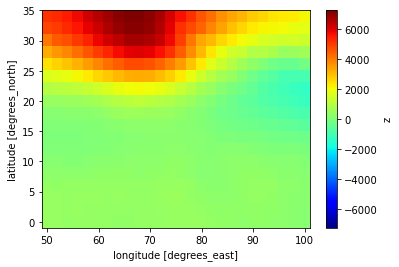

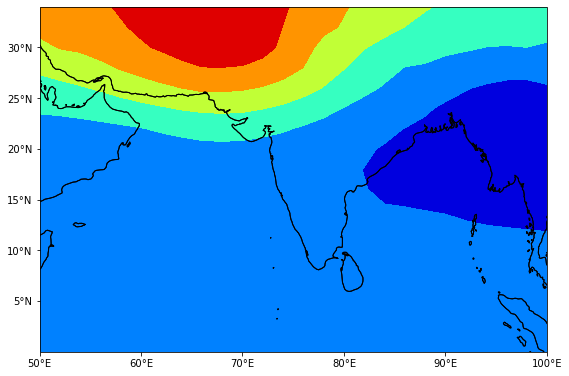

In [71]:
# Get Composite anomoaly for fog days
wfdComp=wfdZ.mean(dim="time")
#wfdComp.plot()


wfdCompSmall=wfdComp.sel(latitude=slice(35,0),longitude=slice(50,100))
print(mask[0,:,:].shape)
wfdCompSmall.values=wfdCompSmall.values*500.0
wfdCompSmall.plot(cmap="jet")


fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121,projection=ccrs.PlateCarree())
m1=ax1.contourf(wfdCompSmall.longitude.values,wfdCompSmall.latitude.values,wfdCompSmall,transform=ccrs.PlateCarree(),cmap='jet')
#xr.plot.contour(zwideNeg.sel(latitude=slice(70,0),longitude=slice(20,150)).mean(dim='time'),figsize=[10,5],levels=np.linspace(-60,60,21 ),colors ='black',   transform=ccrs.PlateCarree())
map_plot(ax1)
ax1.coastlines()
#ax1.set_title('GFDL Neg Widespread Fog Days')

In [72]:
wfdZComp_cube=wfdComp.to_iris()
wfdZComp_cube
wfdZComp_cube_small=wfdCompSmall.to_iris()
wfdZComp_cube_small

Z (unknown),latitude,longitude
Shape,18,26
Dimension coordinates,,
latitude,x,-
longitude,-,x


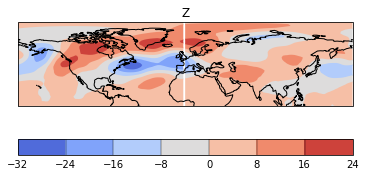

In [16]:
# Load a Cynthia Brewer palette.
brewer_cmap = mpl_cm.get_cmap("brewer_PuOr_11")

# Draw the contours, with n-levels set for the map colours (9).
# NOTE: needed as the map is non-interpolated, but matplotlib does not provide
# any special behaviour for these.
qplt.contourf(wfdZComp_cube,cmap='coolwarm')

# Add coastlines to the map created by contourf.
plt.gca().coastlines()

plt.show()

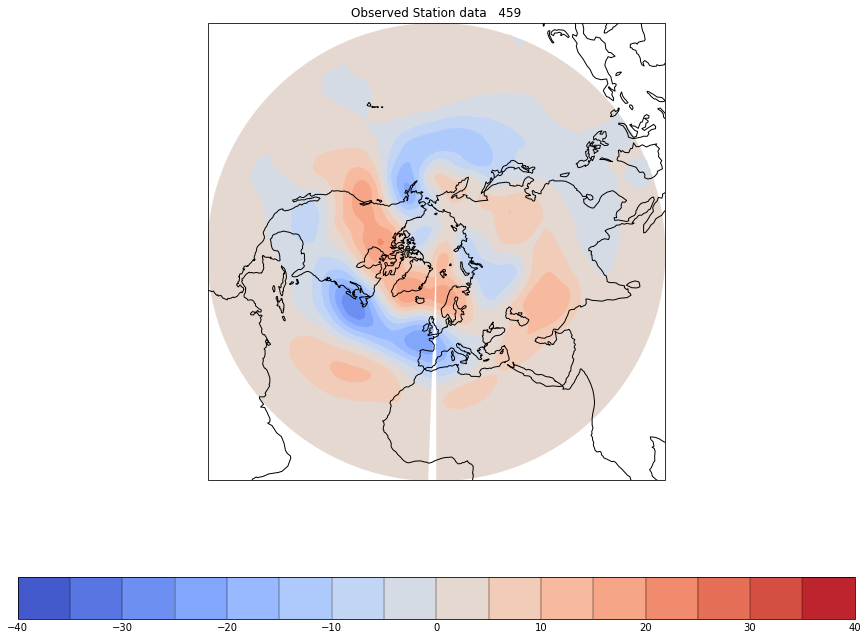

In [51]:
fig = plt.figure(figsize=(15,12))
levels = (-40,-35,-30,-25,-20,-15,-10,-5, 0,5,10,15,20,25,30,35,40)
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0))
#ax.set_global()

# Northern Hemisphere from 23 degrees north:
ax.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())
qplt.contourf(wfdZComp_cube,cmap='coolwarm',levels=levels)
ax.set_title('Observed Station data   '+str(ndays))
ax.coastlines()
plt.savefig('Sttaionobs_WFD-Comp.eps')
qplt.show()

#plt.show()

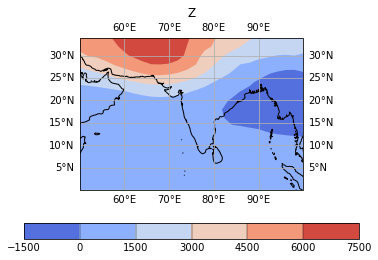

In [73]:
#levels = (-15,-12.5,-10,-7.5,-5, -2.5,0,2.5,5,7.5,10,12.5,15)

#qplt.contourf(wfdZComp_cube_small, cmap='coolwarm',levels=levels)
qplt.contourf(wfdZComp_cube_small, cmap='coolwarm')

#qplt.contourf(wfdZComp_cube, brewer_cmap.N, cmap=brewer_cmap,levels=levels)

# Add coastlines to the map created by contourf.
plt.gca().coastlines()
plt.gca().gridlines(draw_labels=True)


plt.savefig('demo_cnn.eps')
plt.show()

# Positive Anomalies

In [31]:
zwidePos=wfdZ.where(wfdZ.sel(latitude=slice(40,20),longitude=slice(60,85)).mean(dim=['latitude','longitude']) > 0.0, drop=True)
PosCnt=zwidePos.time.sizes
print(PosCnt)
zwidePosComp=zwidePos.mean(dim="time")

Frozen({'time': 286})


In [19]:
zwidePosComp_cube=zwidePosComp.to_iris()
zwidePosComp_cube
zwidePosComp_cube_small=zwidePosComp.sel(latitude=slice(50,0),longitude=slice(30,120)).to_iris()
zwidePosComp_cube_small

Z (unknown),latitude,longitude
Shape,26,46
Dimension coordinates,,
latitude,x,-
longitude,-,x


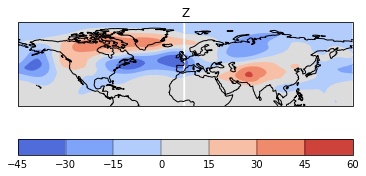

In [30]:
# Draw the contours, with n-levels set for the map colours (9).
# NOTE: needed as the map is non-interpolated, but matplotlib does not provide
# any special behaviour for these.
qplt.contourf(zwidePosComp_cube,cmap='coolwarm')

# Add coastlines to the map created by contourf.
plt.gca().coastlines()

plt.show()

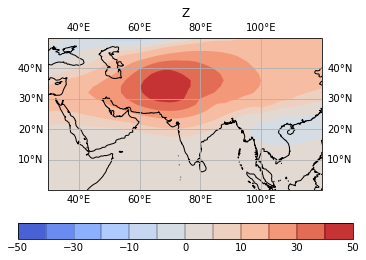

In [29]:
levels = (-50,-40,-30,-20,-10, -5,0,5,10,20,30,40,50)

qplt.contourf(zwidePosComp_cube_small, cmap='coolwarm',levels=levels)

#qplt.contourf(wfdZComp_cube, brewer_cmap.N, cmap=brewer_cmap,levels=levels)

# Add coastlines to the map created by contourf.
plt.gca().coastlines()
plt.gca().gridlines(draw_labels=True)

# Negative Anomalies 

In [33]:
zwideNeg=wfdZ.where(wfdZ.sel(latitude=slice(40,20),longitude=slice(60,85)).mean(dim=['latitude','longitude']) < 0.0, drop=True)
NegCnt=zwideNeg.time.sizes
print(NegCnt)
zwideNegComp=zwideNeg.mean(dim="time")

Frozen({'time': 173})


In [34]:
zwideNegComp_cube=zwideNegComp.to_iris()
zwideNegComp_cube
zwideNegComp_cube_small=zwideNegComp.sel(latitude=slice(50,0),longitude=slice(30,120)).to_iris()
zwideNegComp_cube_small

Z (unknown),latitude,longitude
Shape,26,46
Dimension coordinates,,
latitude,x,-
longitude,-,x


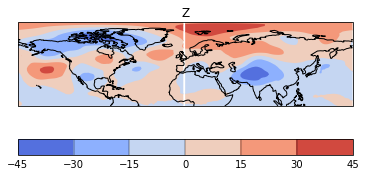

In [35]:
qplt.contourf(zwideNegComp_cube,cmap='coolwarm')

# Add coastlines to the map created by contourf.
plt.gca().coastlines()

plt.show()

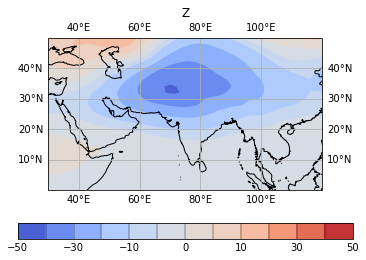

In [36]:
levels = (-50,-40,-30,-20,-10, -5,0,5,10,20,30,40,50)

qplt.contourf(zwideNegComp_cube_small, cmap='coolwarm',levels=levels)

#qplt.contourf(wfdZComp_cube, brewer_cmap.N, cmap=brewer_cmap,levels=levels)

# Add coastlines to the map created by contourf.
plt.gca().coastlines()
plt.gca().gridlines(draw_labels=True)